In [2]:
import os
import numpy as np
#%matplotlib inline
import matplotlib.pyplot as plt
plt.ion()

#%load_ext autoreload
#%autoreload 2
import nbodykit
import Corrfunc

from Corrfunc.mocks.DDsmu_mocks import DDsmu_mocks
from Corrfunc.utils import compute_amps
from Corrfunc.utils import evaluate_xi
from Corrfunc.bases import bao

# Iterative BAO

### Set up parameters

Here we use a low-density lognormal simulation box.

In [3]:
boxsize = 750
nbar_str = '3e-4'

rmin = 40
rmax = 150
nbins = 11

mumax = 1.0
seed = 9
#weight_type='pair_product'
weight_type=None

In [4]:
rbins = np.linspace(rmin, rmax, nbins+1)
rcont = np.linspace(rmin, rmax, 1000)

cat_tag = '_L{}_nbar{}'.format(boxsize, nbar_str)
cat_dir = '../byebyebias/catalogs/cats_lognormal{}'.format(cat_tag)

cosmo = 1 #doesn't matter bc passing cz, but required
nthreads = 24
nmubins = 1
verbose = False

### Load in data and randoms

In [5]:
# data
datasky_fn = '{}/catsky_lognormal{}_seed{}.dat'.format(cat_dir, cat_tag, seed)
datasky = np.loadtxt(datasky_fn)
ra, dec, z = datasky.T
nd = datasky.shape[0]
#weights = np.full(nd, 0.5)
weights = None

In [6]:
# randoms
randsky_fn = '{}/randsky{}_10x.dat'.format(cat_dir, cat_tag)
randomsky = np.loadtxt(randsky_fn)
ra_rand, dec_rand, z_rand = randomsky.T
nr = randomsky.shape[0]
#weights_rand = np.full(nr, 0.5)
weights_rand = None

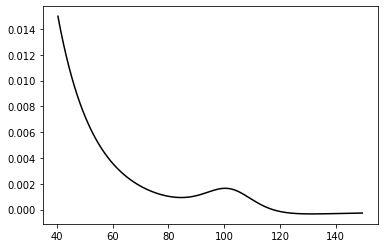

In [7]:
r_true, xi_true, _ = np.load('{}/cf_lin_true{}.npy'.format(cat_dir, cat_tag), allow_pickle=True, encoding='latin1')
xi_true = [xi_true[i] for i in range(len(r_true)) if rmin<=r_true[i]<rmax]
r_true = [r_true[i] for i in range(len(r_true)) if rmin<=r_true[i]<rmax]
plt.plot(r_true, xi_true, color='k')

# BAO on mock data

In [8]:
base_colors = ['magenta', 'red', 'orange', 'green', 'blue']
base_names = ['a1', 'a2', 'a3', 'Bsq', 'C']

Check out bases

In [9]:
proj_type = 'generalr'
projfn = 'bao.dat'
# The spline routine writes to file, so remember to delete later
kwargs = {'cosmo_base':nbodykit.cosmology.Planck15, 'redshift':0, 'dalpha':0.01, 'alpha_model':1.05}
nprojbins, _ = bao.write_bases(rbins[0], rbins[-1], projfn, **kwargs)
bases = np.loadtxt(projfn)
plot_bases(bases)

dalpha: 0.01, alpha_model: 1.05


NameError: name 'plot_bases' is not defined

In [ ]:
def plot_bases(bases):
    plt.figure()
    bases.shape
    r = bases[:,0]
    for i in range(len(bases[0])-1):
        #norm = np.mean(bases[:,i])
        base = bases[:,i+1]
        plt.plot(r, base, color=base_colors[i], label='{}'.format(base_names[i]))
    plt.legend()

In [ ]:
def run_estimator(proj_type, nprojbins, projfn):
    _, dd_proj, _ = DDsmu_mocks(1, cosmo, nthreads, mumax, nmubins, rbins, ra, dec, z,
                    is_comoving_dist=True, proj_type=proj_type, nprojbins=nprojbins, projfn=projfn,
                    verbose=verbose, weights1=weights, weight_type=weight_type)

    _, dr_proj, _ = DDsmu_mocks(0, cosmo, nthreads, mumax, nmubins, rbins, 
                    ra, dec, z, RA2=ra_rand, DEC2=dec_rand, CZ2=z_rand, 
                    is_comoving_dist=True, proj_type=proj_type, nprojbins=nprojbins, projfn=projfn, verbose=verbose,
                    weights1=weights, weights2=weights_rand, weight_type=weight_type)

    _, rr_proj, qq_proj = DDsmu_mocks(1, cosmo, nthreads, mumax, nmubins, rbins, ra_rand, dec_rand, z_rand,
                    is_comoving_dist=True, proj_type=proj_type, nprojbins=nprojbins, projfn=projfn, verbose=verbose,
                    weights1=weights_rand, weight_type=weight_type)
    
    amps = compute_amps(nprojbins, nd, nd, nr, nr, dd_proj, dr_proj, dr_proj, rr_proj, qq_proj)
    print("amplitudes:",amps)
    xi_proj = evaluate_xi(nprojbins, amps, len(rcont), rcont, len(rbins)-1, rbins, proj_type, projfn=projfn)
    return amps, xi_proj

In [ ]:
def plot_bao(bases, amps):
    plt.figure()
    total = np.zeros(len(bases))
    r = bases[:,0]
    for i in range(0, bases.shape[1]-1):
        ampbase =  amps[i]*bases[:,i+1]
        total += ampbase
        plt.plot(rcont, ampbase, color=base_colors[i], label='{} = {:.4f}'.format(base_names[i], amps[i]))
    plt.plot(r, total, color='purple', label='total', lw=3, ls='-.')
    plt.plot(r_true, xi_true, color='k')
    plt.xlabel(r'$r (h^{-1}Mpc)$')
    plt.ylabel(r'$\xi(r)$')
    plt.xlim(rmin, rmax)
    plt.legend()

In [ ]:
def bao_iterative(dalpha, alpha_model):

    proj_type = 'generalr'
    projfn = 'bao.dat'
    # The spline routine writes to file, so remember to delete later
    kwargs = {'cosmo_base':nbodykit.cosmology.Planck15, 'redshift':0, 'dalpha':dalpha, 'alpha_model':alpha_model}
    nprojbins, _ = bao.write_bases(rbins[0], rbins[-1], projfn, **kwargs)
    bases = np.loadtxt(projfn)
    
    #plot_bases(bases)
    
    amps, xi_proj = run_estimator(proj_type, nprojbins, projfn)
    
    plot_bao(bases, amps)
    
    return amps

In [ ]:
alpha_model = 1.03
dalpha = 0.01*alpha_model
amps = bao_iterative(dalpha, alpha_model)

In [ ]:
C = amps[4]
alpha_model = alpha_model+dalpha*C
dalpha = 0.01*alpha_model
amps = bao_iterative(dalpha, alpha_model)

In [ ]:
C = amps[4]
alpha_model = alpha_model+dalpha*C
dalpha = 0.01*alpha_model
amps = bao_iterative(dalpha, alpha_model)

In [ ]:
C = amps[4]
alpha_model = alpha_model+dalpha*C
dalpha = 0.01*alpha_model
amps = bao_iterative(dalpha, alpha_model)

In [ ]:
# Start with diff model

alpha_model = 1.06
dalpha = 0.01*alpha_model
amps = bao_iterative(dalpha, alpha_model)

In [ ]:
C = amps[4]
alpha_model = alpha_model+dalpha*C
dalpha = 0.01*alpha_model
amps = bao_iterative(dalpha, alpha_model)

In [ ]:
C = amps[4]
alpha_model = alpha_model+dalpha*C
dalpha = 0.01*alpha_model
amps = bao_iterative(dalpha, alpha_model)

dalpha: 0.009666602881230918, alpha_model: 0.9666602881230918
Applying projection requires fallback method, switching instruction set
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data
Applying projection requires fallback method, switching instruction set
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data
Applying projection requires fallback method, switching instruction set
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data
Computing amplitudes (Corrfunc/utils)
amplitudes: [-1.46212715e+01  4.29338896e+00 -2.96024565e+00  1.00772271e+00
 -6.58077912e-04]
Evaluating xi (Corrfunc/utils)
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data


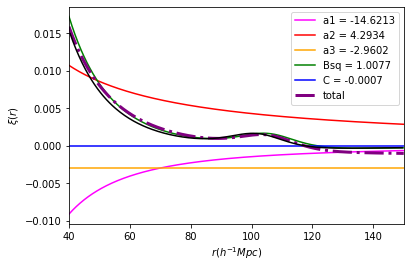

In [19]:
C = amps[4]
alpha_model = alpha_model+dalpha*C
dalpha = 0.01*alpha_model
amps = bao_iterative(dalpha, alpha_model)

Converged to same value!!

dalpha: 0.0098, alpha_model: 0.98
Applying projection requires fallback method, switching instruction set
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data
Applying projection requires fallback method, switching instruction set
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data
Applying projection requires fallback method, switching instruction set
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data
Computing amplitudes (Corrfunc/utils)
amplitudes: [-13.80175396   4.1852515   -2.9233508    0.9905441   -1.3876568 ]
Evaluating xi (Corrfunc/utils)
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data


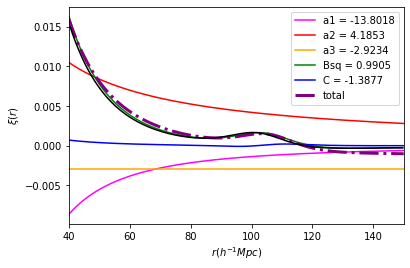

In [20]:
# Start with diff model

alpha_model = 0.98
dalpha = 0.01*alpha_model
amps = bao_iterative(dalpha, alpha_model)

dalpha: 0.009664009633587017, alpha_model: 0.9664009633587017
Applying projection requires fallback method, switching instruction set
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data
Applying projection requires fallback method, switching instruction set
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data
Applying projection requires fallback method, switching instruction set
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data
Computing amplitudes (Corrfunc/utils)
amplitudes: [-14.62752529   4.29419283  -2.96050403   1.00786869   0.02709588]
Evaluating xi (Corrfunc/utils)
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data


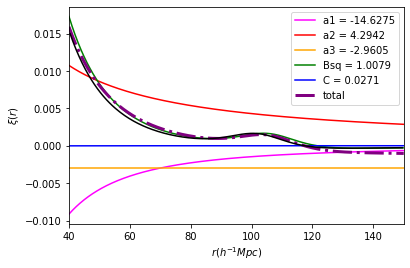

In [21]:
C = amps[4]
alpha_model = alpha_model+dalpha*C
dalpha = 0.01*alpha_model
amps = bao_iterative(dalpha, alpha_model)

dalpha: 0.009666628182505403, alpha_model: 0.9666628182505403
Applying projection requires fallback method, switching instruction set
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data
Applying projection requires fallback method, switching instruction set
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data
Applying projection requires fallback method, switching instruction set
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data
Computing amplitudes (Corrfunc/utils)
amplitudes: [-1.46212085e+01  4.29338085e+00 -2.96024304e+00  1.00772125e+00
 -9.28729912e-04]
Evaluating xi (Corrfunc/utils)
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data


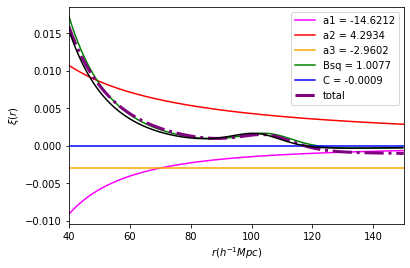

In [22]:
C = amps[4]
alpha_model = alpha_model+dalpha*C
dalpha = 0.01*alpha_model
amps = bao_iterative(dalpha, alpha_model)

dalpha: 0.009666538405637944, alpha_model: 0.9666538405637943
Applying projection requires fallback method, switching instruction set
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data
Applying projection requires fallback method, switching instruction set
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data
Applying projection requires fallback method, switching instruction set
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data
Computing amplitudes (Corrfunc/utils)
amplitudes: [-1.46214318e+01  4.29340960e+00 -2.96025231e+00  1.00772643e+00
  3.16397879e-05]
Evaluating xi (Corrfunc/utils)
Reading in projection file, bao.dat...
Read in 1000 by 6 basis data


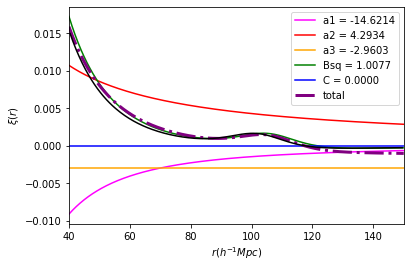

In [23]:
C = amps[4]
alpha_model = alpha_model+dalpha*C
dalpha = 0.01*alpha_model
amps = bao_iterative(dalpha, alpha_model)

In [19]:
#!jupyter nbconvert --to script example.ipynb